In [1]:
from pathlib import Path
import os
import sys
from datetime import datetime
import numpy as np
from functools import partial

In [2]:
PROJECT_DIR = Path(os.getcwd()).resolve().parent
PROJECT_DIR

PosixPath('/home/nico/Thesis/neural-artwork-caption-generator')

In [3]:
sys.path.append(str(PROJECT_DIR))

In [4]:
from src.models.multiclassification.model import ViTForMultiClassification
from src.models.multiclassification.losses import losses_fn, join_losses
from src.models.multiclassification.train_model import find_last_checkpoint
from src.models.multiclassification.data import get_multiclassification_dicts, compute_class_weight_tensors, transform_for_model
from src.utils.dirutils import get_data_dir
from datasets import Dataset, load_from_disk
from transformers import ViTImageProcessor
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

/home/nico/Thesis/neural-artwork-caption-generator/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
multiclass_classifications, multilabel_classifications = get_multiclassification_dicts()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset: Dataset = load_from_disk(
    get_data_dir() / "processed" / "multiclassification_dataset"
)
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

In [7]:
class_weight_tensors = compute_class_weight_tensors(dataset, device)

In [8]:
model = ViTForMultiClassification(multiclass_classifications, multilabel_classifications)
model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ViTForMultiClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [9]:
model_output_dir = PROJECT_DIR / "models" / "multiclassification" / "heads"
last_checkpoint = find_last_checkpoint(model_output_dir)
last_checkpoint

PosixPath('/home/nico/Thesis/neural-artwork-caption-generator/models/multiclassification/heads/model-20230504_204321-3.pt')

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [11]:
checkpoint = torch.load(last_checkpoint)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

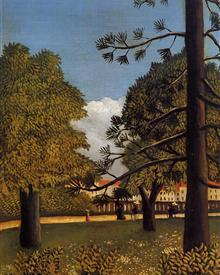

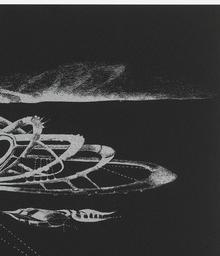

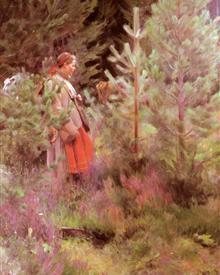

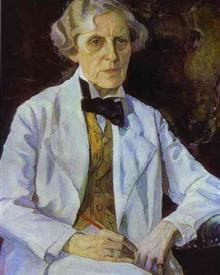

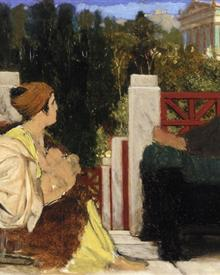

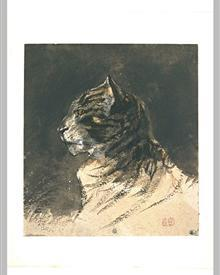

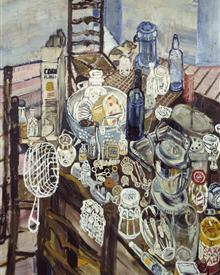

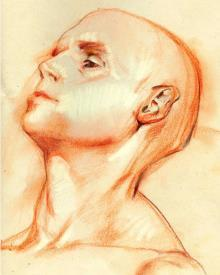

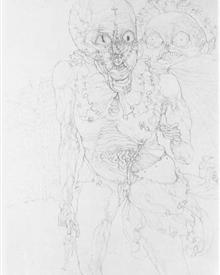

In [12]:
for i, example in enumerate(dataset["validation"]):
    display(example["image"])
    if i >= 8:
        break

In [13]:
dataset["validation"] = dataset["validation"].with_transform(partial(transform_for_model, processor=processor, device=device))

In [14]:
dataloader = torch.utils.data.DataLoader(
    dataset["validation"],
    batch_size=8,
)

In [17]:
running_losses = [0.] * 5

for batch in tqdm(dataloader):
    with torch.no_grad():
        inputs, targets = batch["pixel_values"], {k: batch[k] for k in batch if k != "pixel_values"}
        outputs = model(inputs)
        losses = losses_fn(multiclass_classifications.keys(), multilabel_classifications.keys(), outputs, targets, class_weight_tensors)

        for i, loss in enumerate(losses):
            running_losses[i] += loss.item() / 4

running_losses

 79%|███████▉  | 1727/2175 [06:54<01:47,  4.17it/s]


KeyboardInterrupt: 